# Projet Neural Network - Corporación Favorita Grocery Sales Forecasting

Brick-and-mortar grocery stores are always in a delicate dance with purchasing and sales forecasting. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leaving money on the table and customers fuming.

The problem becomes more complex as retailers add new locations with unique needs, new products, ever transitioning seasonal tastes, and unpredictable product marketing. Corporación Favorita, a large Ecuadorian-based grocery retailer, knows this all too well. They operate hundreds of supermarkets, with over 200,000 different products on their shelves.

Corporación Favorita has challenged the Kaggle community to build a model that more accurately forecasts product sales. They currently rely on subjective forecasting methods with very little data to back them up and very little automation to execute plans. They’re excited to see how machine learning could better ensure they please customers by having just enough of the right products at the right time.

## I - Imports

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random as rd
from tqdm import tqdm

from neural_network import neural_net_model, neural_net_model_3layers, rnn_model

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/louisgiron/Desktop/ENSAE - Mastère spé/Reseaux de neurones/projet_nn/processing_data.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train_small['unit_sales'] = train_small['unit_sales'].apply(lambda x:


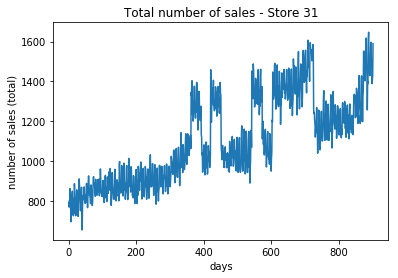

              Number of missing values  Share of missing
id                                   0              0.00
date                                 0              0.00
store_nbr                            0              0.00
item_nbr                             0              0.00
unit_sales                           0              0.00
onpromotion                   21657651             43.32
city                                 0              0.00
state                                0              0.00
type_x                               0              0.00
cluster                              0              0.00
dcoilwtico                    15973592             31.95
type_y                        43102131             86.20
locale                        43102131             86.20
locale_name                   43102131             86.20
description                   43102131             86.20
transferred                   43102131             86.20
family                         

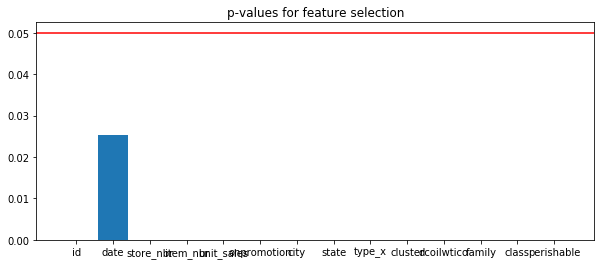

X train original shape: (125497040, 6)
X train processed shape: (50000000, 14)


In [2]:
from processing_data import train_all_processed

## II - Training setup

In [3]:
# Train size
train_size_ratio = 0.6
valid_train_size_ratio = 0.1

size = train_all_processed.shape[0]

train_set = np.arange(0, int(train_size_ratio*size))
valid_set = np.arange(int(train_size_ratio*size), int(train_size_ratio*size)
                      + int(valid_train_size_ratio*size))
test_set = np.arange(int(train_size_ratio*size+valid_train_size_ratio*size),
                     int(size))

# Split the train data to learn # Warning date -> split linearly
X_train = train_all_processed.drop(['unit_sales'], axis=1).loc[train_set]
y_train = train_all_processed['unit_sales'].loc[train_set]
X_valid = train_all_processed.drop(['unit_sales'], axis=1).loc[valid_set]
y_valid = train_all_processed['unit_sales'].loc[valid_set]
X_test = train_all_processed.drop(['unit_sales'], axis=1).loc[test_set]
y_test = train_all_processed['unit_sales'].loc[test_set]

# Norlmalize data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train.values)
y_train_norm = scaler.fit_transform(y_train.values.reshape(-1, 1))

X_valid_norm = scaler.fit_transform(X_valid.values)
y_valid_norm = scaler.fit_transform(y_valid.values.reshape(-1, 1))

X_test_norm = scaler.fit_transform(X_test.values)
y_test_norm = scaler.fit_transform(y_test.values.reshape(-1, 1))

print('X train shape:', X_train.shape)
print('X valid shape:', X_valid.shape)
print('X test shape:', X_test.shape)

def denormalize(y_train, norm_data):
    try:
        df = y_train.values.reshape(-1, 1)
    except AttributeError:
        df = y_train.reshape(-1, 1)
    norm_data = norm_data.reshape(-1, 1)
    scl = MinMaxScaler()
    scl.fit_transform(df)
    return scl.inverse_transform(norm_data)

X train shape: (30000000, 13)
X valid shape: (5000000, 13)
X test shape: (15000000, 13)


## III - 2 layers neural network

### A - Model initialization

In [4]:
# Input data
nb_epoch = 20
nb_input = X_train.shape[1]
nb_hidden1 = 10
nb_hidden2 = 6
batch_size = 50000

# Initialize the model
X_tf = tf.placeholder(tf.float32)
y_tf = tf.placeholder(tf.float32)
keep_prob_1 = tf.placeholder(tf.float32)
keep_prob_2 = tf.placeholder(tf.float32)

output = neural_net_model(X_tf, nb_input, nb_hidden1, nb_hidden2, keep_prob_1, keep_prob_2)
avg_cost_v = []
c_t = []
c_valid = []
l_rate_v = []

# Drop out level
prob_1 = 0.6
prob_2 = 0.6

cost = tf.reduce_mean(tf.square(output-y_tf))
'''
# Piecewise constant
min_lr = 0.1
max_lr = 0.5
nb_values = nb_epoch

global_step = tf.Variable(0, trainable=False)
boundaries = list(np.linspace(batch_size,
                              batch_size*nb_epoch, nb_values,
                              dtype=np.int32)[:-1])
values = list(np.round(np.linspace(max_lr, min_lr, nb_values), 2))
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

j = 0
# Passing global_step to minimize() will increment it at each step.
learning_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost,
                                                                 global_step=global_step)'''

# Exponential decay of the learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           int(X_train.shape[0]/batch_size),
                                           0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
learning_step = (
    tf.train.AdamOptimizer(learning_rate).minimize(cost,
                                                   global_step=global_step))
j = 0

### B - Model training

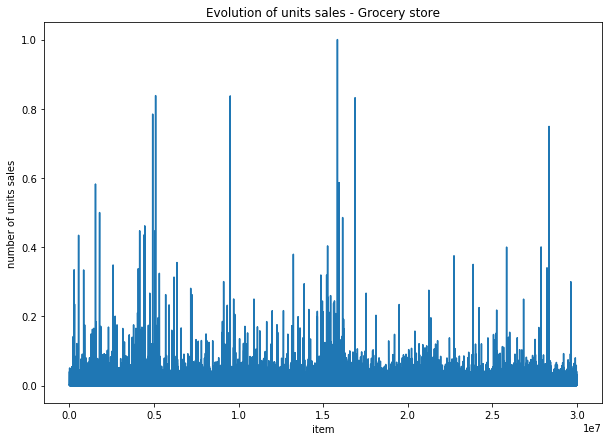

In [ ]:
# Initial plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
plt.xlabel('item')
plt.ylabel('number of units sales')
plt.title('Evolution of units sales - Grocery store')
ax.plot(range(len(y_train)), y_train_norm, label='Original')
plt.show()

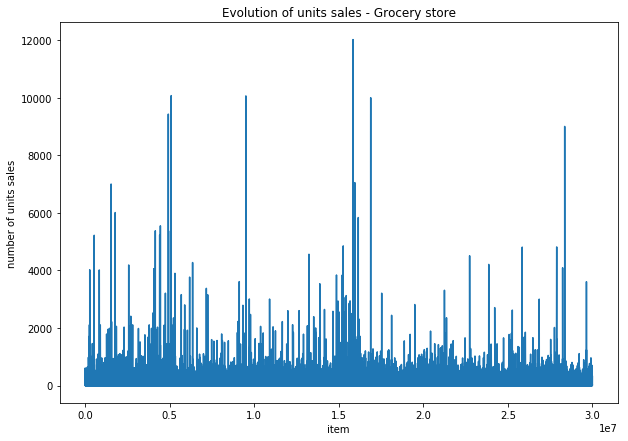

  5%|▌         | 1/20 [00:39<12:35, 39.76s/it]

Epoch : 1 Cost train: 5.326959353624261e-09 Cost valid: 1.653429e-05 Learning rate: [0.1]


 10%|█         | 2/20 [00:58<10:00, 33.34s/it]

Epoch : 2 Cost train: 5.332394342379605e-09 Cost valid: 1.6522588e-05 Learning rate: [0.096]


 15%|█▌        | 3/20 [01:23<08:44, 30.85s/it]

Epoch : 3 Cost train: 5.372212399379351e-09 Cost valid: 1.6590824e-05 Learning rate: [0.09216]


 20%|██        | 4/20 [01:42<07:17, 27.36s/it]

Epoch : 4 Cost train: 5.426394788325221e-09 Cost valid: 1.6581545e-05 Learning rate: [0.088473596]


 25%|██▌       | 5/20 [02:00<06:08, 24.58s/it]

Epoch : 5 Cost train: 5.334474811509911e-09 Cost valid: 1.632877e-05 Learning rate: [0.084934644]


 30%|███       | 6/20 [02:18<05:16, 22.62s/it]

Epoch : 6 Cost train: 5.249065679890918e-09 Cost valid: 1.6137637e-05 Learning rate: [0.08153726]


 35%|███▌      | 7/20 [02:37<04:38, 21.43s/it]

Epoch : 7 Cost train: 5.289195996738272e-09 Cost valid: 1.6221944e-05 Learning rate: [0.07827577]


 40%|████      | 8/20 [02:52<03:55, 19.64s/it]

Epoch : 8 Cost train: 5.3788354155888855e-09 Cost valid: 1.6152399e-05 Learning rate: [0.07514474]


 45%|████▌     | 9/20 [03:05<03:12, 17.53s/it]

Epoch : 9 Cost train: 5.374857892093132e-09 Cost valid: 1.617033e-05 Learning rate: [0.07213895]


 50%|█████     | 10/20 [03:17<02:40, 16.07s/it]

Epoch : 10 Cost train: 5.158707381269778e-09 Cost valid: 1.5274802e-05 Learning rate: [0.069253385]


 55%|█████▌    | 11/20 [03:30<02:15, 15.07s/it]

Epoch : 11 Cost train: 5.380241721771502e-09 Cost valid: 1.5395255e-05 Learning rate: [0.06648325]


 60%|██████    | 12/20 [03:42<01:51, 13.97s/it]

Epoch : 12 Cost train: 5.157259768869456e-09 Cost valid: 1.5675312e-05 Learning rate: [0.063823916]


 65%|██████▌   | 13/20 [03:53<01:32, 13.18s/it]

Epoch : 13 Cost train: 5.199356868009393e-09 Cost valid: 1.5493384e-05 Learning rate: [0.06127096]


 70%|███████   | 14/20 [04:04<01:15, 12.57s/it]

Epoch : 14 Cost train: 5.2300545879309844e-09 Cost valid: 1.551171e-05 Learning rate: [0.058820125]


 75%|███████▌  | 15/20 [04:15<01:00, 12.14s/it]

Epoch : 15 Cost train: 5.38534209226782e-09 Cost valid: 1.5908001e-05 Learning rate: [0.056467313]


 80%|████████  | 16/20 [04:26<00:47, 11.85s/it]

Epoch : 16 Cost train: 5.148858690517954e-09 Cost valid: 1.5730091e-05 Learning rate: [0.054208618]


 85%|████████▌ | 17/20 [04:38<00:34, 11.67s/it]

Epoch : 17 Cost train: 5.730652977338953e-09 Cost valid: 1.5292939e-05 Learning rate: [0.052040275]


 90%|█████████ | 18/20 [04:49<00:23, 11.53s/it]

Epoch : 18 Cost train: 7.009925108529084e-09 Cost valid: 1.5129263e-05 Learning rate: [0.04995866]


 95%|█████████▌| 19/20 [05:00<00:11, 11.40s/it]

Epoch : 19 Cost train: 6.1861286818990875e-09 Cost valid: 1.5188113e-05 Learning rate: [0.047960315]


100%|██████████| 20/20 [05:11<00:00, 11.36s/it]

Epoch : 20 Cost train: 5.9783159637542364e-09 Cost valid: 1.5270976e-05 Learning rate: [0.046041902]


Cost - Test phase: 5.3378785e-06


In [ ]:
# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    y_t = denormalize(y_train, y_train_norm)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlabel('item')
    plt.ylabel('number of units sales')
    plt.title('Evolution of units sales - Grocery store')
    ax.plot(range(len(y_train)), y_t, label='Original')
    plt.show()

    '''try:
        saver.restore(sess, 'NN_favorita_grocery_sales.ckpt')
    except Exception:
        pass'''

    for epoch in tqdm(range(nb_epoch)):

        # Create the batches
        total_batch = int(X_train.shape[0]/batch_size)

        # Run training on batch
        for i in range(total_batch):
            avg_cost = 0.
            # Increment the learning rate with exponential decay
            l_rate = sess.run([learning_rate], {global_step: j})
            l_rate_v.append(l_rate)
            j += 1

            batch_X = X_train_norm[i*batch_size:(i+1)*batch_size]
            batch_y = y_train_norm[i*batch_size:(i+1)*batch_size]

            # Run the train
            _, c = sess.run([learning_step, cost],
                            feed_dict={X_tf: batch_X, y_tf: batch_y,
                                       keep_prob_1: prob_1,
                                       keep_prob_2: prob_2})
            # Compute average cost on train set
            c_t.append(c)
            avg_cost += c / total_batch
        avg_cost_v.append(avg_cost)
        
        # Compute the cost on valid set
        pred_norm, cost_valid = sess.run([output, cost],
                                         feed_dict={X_tf: X_valid_norm,
                                                    y_tf: y_valid_norm,
                                                    keep_prob_1: 1.0,
                                                    keep_prob_2: 1.0})
        c_valid.append(cost_valid)
        pred = denormalize(y_train, pred_norm)

        print('Epoch :', epoch+1, 'Cost train:', avg_cost_v[epoch], 'Cost valid:', c_valid[epoch],
              'Learning rate:', l_rate)

    # Compute the cost on test set
    print('Cost - Test phase:', sess.run(cost, feed_dict={X_tf: X_test_norm,
                                                          y_tf: y_test_norm,
                                                          keep_prob_1: 1.0,
                                                          keep_prob_2: 1.0}))
    pred_test_norm = sess.run(output, feed_dict={X_tf: X_test_norm,
                                                keep_prob_1: 1.0,
                                                keep_prob_2: 1.0})
    pred_test = denormalize(y_train, pred_test_norm)

    '''
    # Save the model
    if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() +
                   '/nn_saved_sessions/NN_favorita_grocery_sales.ckpt')
        print('Model Saved')'''

    # Close the session
    sess.close()

### C - Visualisation

#### Cost of the prediction

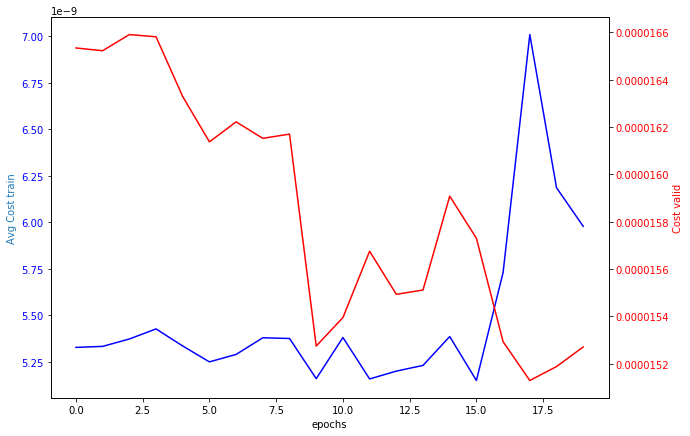

In [ ]:
# Plot the costs
fig, ax1 = plt.subplots(figsize=(10, 7))
x = np.arange(nb_epoch)
ax1.plot(x, avg_cost_v, 'b-')
ax1.set_xlabel('epochs')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Avg Cost train', color='C0')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(x, c_valid, 'r-')
ax2.set_ylabel('Cost valid', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')  
plt.show()

#### Learning rate through epochs

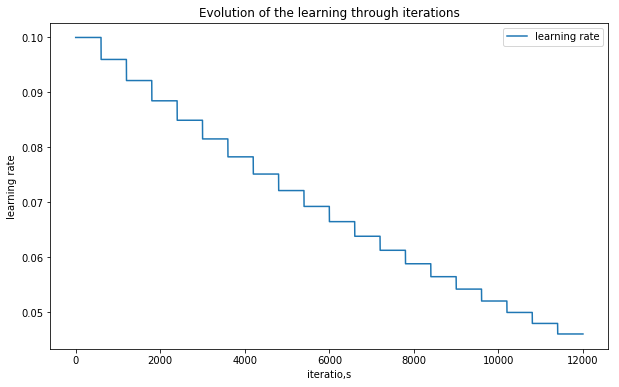

In [ ]:
# Plot the learning rate
plt.figure(figsize=(10, 6))
plt.plot(l_rate_v, label="learning rate")
plt.legend(loc='best')
plt.ylabel('learning rate')
plt.xlabel('iteratio,s')
plt.title('Evolution of the learning through iterations')
plt.show()

#### Normalized predictions against normalized original values
Use to check whether the denormalization process is consistent

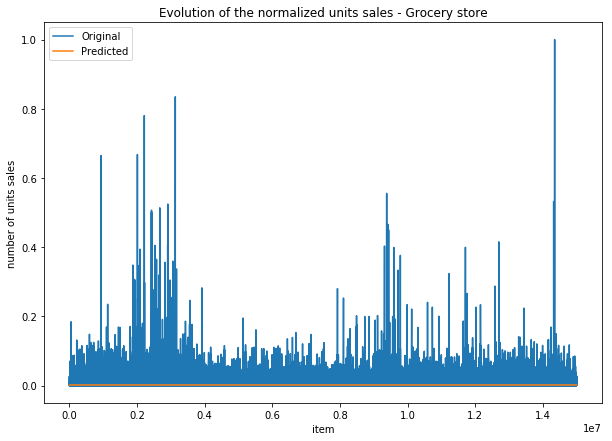

In [ ]:
# Plot normalized predictions vs normalized original
fig = plt.figure(figsize=(10, 7))
plt.plot(y_test_norm, label='Original')
plt.plot(pred_test_norm, label='Predicted')
plt.xlabel('item')
plt.ylabel('number of units sales')
plt.legend(loc='best')
plt.title('Evolution of the normalized units sales - Grocery store')
plt.show()

#### Predictions against original values

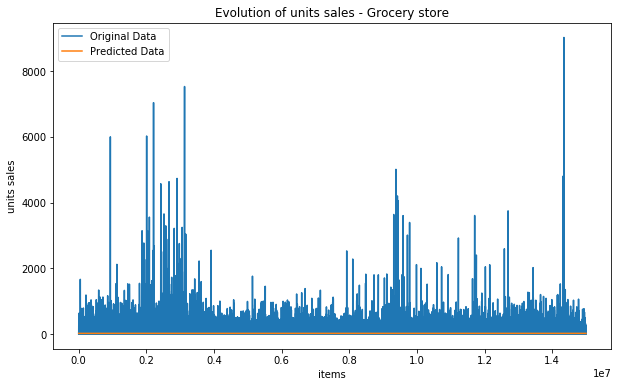

In [ ]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), y_test, label="Original Data")
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

#### Predictions only
Use to observe more precisely the predictions

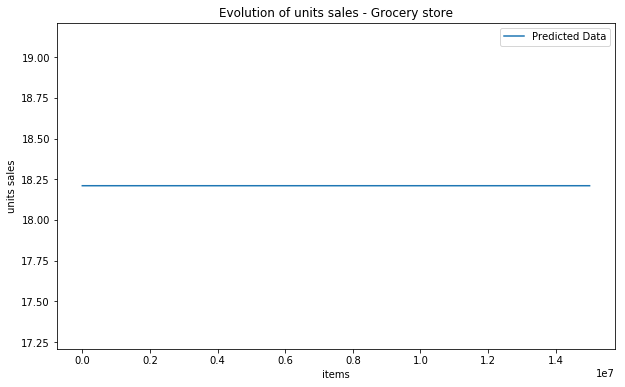

In [ ]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

## IV - 3 layers neural network

### A - Model initialization

In [ ]:
# Input data
nb_epoch = 20
nb_input = X_train.shape[1]
nb_hidden1 = 12
nb_hidden2 = 8
nb_hidden3 = 4
batch_size = 1000

# Initialize the model
X_tf = tf.placeholder(tf.float32)
y_tf = tf.placeholder(tf.float32)
keep_prob_1 = tf.placeholder(tf.float32)
keep_prob_2 = tf.placeholder(tf.float32)
keep_prob_3 = tf.placeholder(tf.float32)

output = neural_net_model_3layers(X_tf, nb_input, nb_hidden1, nb_hidden2, nb_hidden3,
                                  keep_prob_1, keep_prob_2, keep_prob_3)
avg_cost_v = []
c_t = []
c_valid = []
l_rate_v = []

# Drop out level
prob_1 = 0.3
prob_2 = 0.4
prob_3 = 0.5

cost = tf.reduce_mean(tf.square(output-y_tf))
'''
# Piecewise constant
min_lr = 0.1
max_lr = 0.5
nb_values = nb_epoch

global_step = tf.Variable(0, trainable=False)
boundaries = list(np.linspace(batch_size,
                              batch_size*nb_epoch, nb_values,
                              dtype=np.int32)[:-1])
values = list(np.round(np.linspace(max_lr, min_lr, nb_values), 2))
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

j = 0
# Passing global_step to minimize() will increment it at each step.
learning_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost,
                                                                 global_step=global_step)'''

# Exponential decay of the learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           int(X_train.shape[0]/batch_size),
                                           0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
learning_step = (
    tf.train.AdamOptimizer(learning_rate).minimize(cost,
                                                   global_step=global_step))
j = 0

### B - Model training

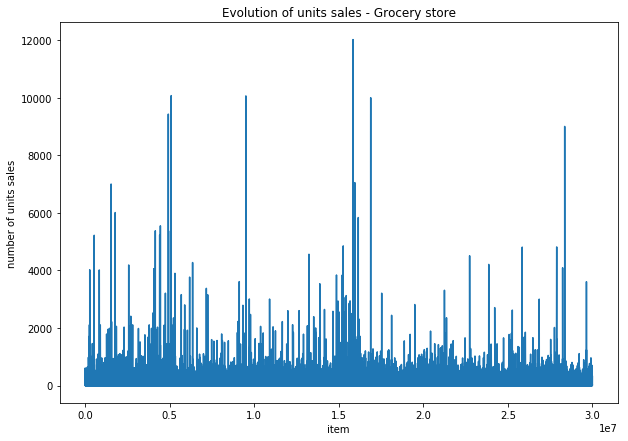

  5%|▌         | 1/20 [00:53<16:52, 53.29s/it]

Epoch : 1 Cost train: 1.2782422042315981e-10 Cost valid: 2.1481037e-05 Learning rate: [0.1]


 10%|█         | 2/20 [01:37<15:09, 50.51s/it]

Epoch : 2 Cost train: 1.37782474970057e-10 Cost valid: 2.28131e-05 Learning rate: [0.096]


 15%|█▌        | 3/20 [02:19<13:36, 48.00s/it]

Epoch : 3 Cost train: 1.5879536476859358e-10 Cost valid: 2.3792334e-05 Learning rate: [0.09216]


 20%|██        | 4/20 [03:08<12:54, 48.40s/it]

Epoch : 4 Cost train: 1.8362025002716108e-10 Cost valid: 2.4238218e-05 Learning rate: [0.088473596]


 25%|██▌       | 5/20 [04:04<12:39, 50.63s/it]

Epoch : 5 Cost train: 1.935041382239433e-10 Cost valid: 2.3957862e-05 Learning rate: [0.084934644]


 30%|███       | 6/20 [04:58<12:02, 51.62s/it]

Epoch : 6 Cost train: 1.5925873716090184e-10 Cost valid: 2.3292967e-05 Learning rate: [0.08153726]


 35%|███▌      | 7/20 [05:53<11:22, 52.50s/it]

Epoch : 7 Cost train: 1.7828938325692434e-10 Cost valid: 2.3513874e-05 Learning rate: [0.07827577]


 40%|████      | 8/20 [06:46<10:33, 52.80s/it]

Epoch : 8 Cost train: 2.0010090035308775e-10 Cost valid: 2.3600891e-05 Learning rate: [0.07514474]


 45%|████▌     | 9/20 [07:40<09:45, 53.23s/it]

Epoch : 9 Cost train: 2.2264005868540456e-10 Cost valid: 2.3310718e-05 Learning rate: [0.07213895]


 50%|█████     | 10/20 [08:37<09:02, 54.21s/it]

Epoch : 10 Cost train: 2.3582266900727213e-10 Cost valid: 2.227252e-05 Learning rate: [0.069253385]


 55%|█████▌    | 11/20 [09:48<08:52, 59.20s/it]

Epoch : 11 Cost train: 2.3173988665803336e-10 Cost valid: 2.1078742e-05 Learning rate: [0.06648325]


 60%|██████    | 12/20 [11:00<08:25, 63.24s/it]

Epoch : 12 Cost train: 2.2696152276087862e-10 Cost valid: 2.0553201e-05 Learning rate: [0.063823916]


 65%|██████▌   | 13/20 [12:26<08:10, 70.08s/it]

Epoch : 13 Cost train: 2.329090117806724e-10 Cost valid: 2.0695814e-05 Learning rate: [0.06127096]


 70%|███████   | 14/20 [13:51<07:25, 74.31s/it]

Epoch : 14 Cost train: 2.473791179606148e-10 Cost valid: 2.081553e-05 Learning rate: [0.058820125]


 75%|███████▌  | 15/20 [15:12<06:22, 76.54s/it]

Epoch : 15 Cost train: 2.471167893721334e-10 Cost valid: 2.0410138e-05 Learning rate: [0.056467313]


 80%|████████  | 16/20 [16:27<05:03, 75.95s/it]

Epoch : 16 Cost train: 2.429632180186066e-10 Cost valid: 2.1723656e-05 Learning rate: [0.054208618]


 85%|████████▌ | 17/20 [17:55<03:58, 79.67s/it]

Epoch : 17 Cost train: 2.583703462732956e-10 Cost valid: 2.1520282e-05 Learning rate: [0.052040275]


 90%|█████████ | 18/20 [19:32<02:49, 84.82s/it]

Epoch : 18 Cost train: 2.5269332581956405e-10 Cost valid: 1.9546947e-05 Learning rate: [0.04995866]


 95%|█████████▌| 19/20 [20:59<01:25, 85.52s/it]

Epoch : 19 Cost train: 3.6452932666482715e-10 Cost valid: 2.099143e-05 Learning rate: [0.047960315]


100%|██████████| 20/20 [22:24<00:00, 85.16s/it]

Epoch : 20 Cost train: 6.577186165183472e-10 Cost valid: 1.7152353e-05 Learning rate: [0.046041902]


Cost - Test phase: 1.0469334e-05


In [ ]:
# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    y_t = denormalize(y_train, y_train_norm)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlabel('item')
    plt.ylabel('number of units sales')
    plt.title('Evolution of units sales - Grocery store')
    ax.plot(range(len(y_train)), y_t, label='Original')
    plt.show()

    '''try:
        saver.restore(sess, 'NN_favorita_grocery_sales.ckpt')
    except Exception:
        pass'''

    for epoch in tqdm(range(nb_epoch)):

        # Create the batches
        total_batch = int(X_train.shape[0]/batch_size)

        # Run training on batch
        for i in range(total_batch):
            avg_cost = 0.
            # Increment the learning rate with exponential decay
            l_rate = sess.run([learning_rate], {global_step: j})
            l_rate_v.append(l_rate)
            j += 1

            batch_X = X_train_norm[i*batch_size:(i+1)*batch_size]
            batch_y = y_train_norm[i*batch_size:(i+1)*batch_size]

            # Run the train
            _, c = sess.run([learning_step, cost],
                            feed_dict={X_tf: batch_X, y_tf: batch_y,
                                       keep_prob_1: prob_1,
                                       keep_prob_2: prob_2,
                                       keep_prob_3: prob_3})
            # Compute average cost on the train set
            c_t.append(c)
            avg_cost += c / total_batch
        avg_cost_v.append(avg_cost)
        
        # Compute the cost on the valid set
        pred_norm, cost_valid = sess.run([output, cost],
                                         feed_dict={X_tf: X_valid_norm,
                                                    y_tf: y_valid_norm,
                                                    keep_prob_1: 1.0,
                                                    keep_prob_2: 1.0,
                                                    keep_prob_3: 1.0})
        c_valid.append(cost_valid)
        pred = denormalize(y_train, pred_norm)

        print('Epoch :', epoch+1, 'Cost train:', avg_cost_v[epoch], 'Cost valid:', c_valid[epoch],
              'Learning rate:', l_rate)

    # Compute the cost on the test set
    print('Cost - Test phase:', sess.run(cost, feed_dict={X_tf: X_test_norm,
                                                          y_tf: y_test_norm,
                                                          keep_prob_1: 1.0,
                                                          keep_prob_2: 1.0,
                                                          keep_prob_3: 1.0}))
    pred_test_norm = sess.run(output, feed_dict={X_tf: X_test_norm,
                                                keep_prob_1: 1.0,
                                                keep_prob_2: 1.0,
                                                keep_prob_3: 1.0})
    pred_test = denormalize(y_train, pred_test_norm)

    '''
    # Save the model
    if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() +
                   '/nn_saved_sessions/NN_favorita_grocery_sales.ckpt')
        print('Model Saved')'''

    # Close the session
    sess.close()

### C - Visualisation

#### Cost of the prediction

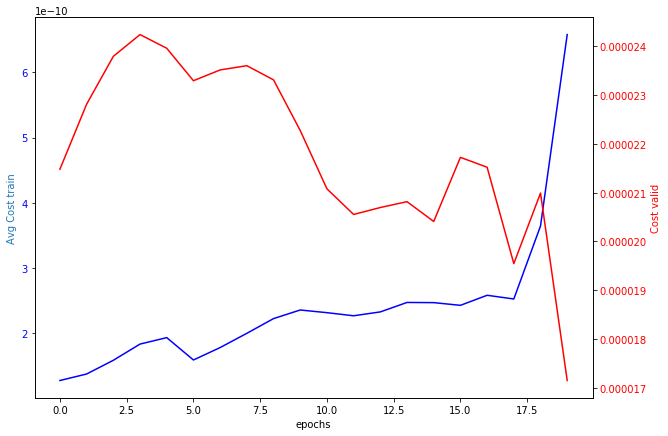

In [ ]:
# Plot the costs
fig, ax1 = plt.subplots(figsize=(10, 7))
x = np.arange(nb_epoch)
ax1.plot(x, avg_cost_v, 'b-')
ax1.set_xlabel('epochs')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Avg Cost train', color='C0')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(x, c_valid, 'r-')
ax2.set_ylabel('Cost valid', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')  
plt.show()

#### Learning rate through epochs

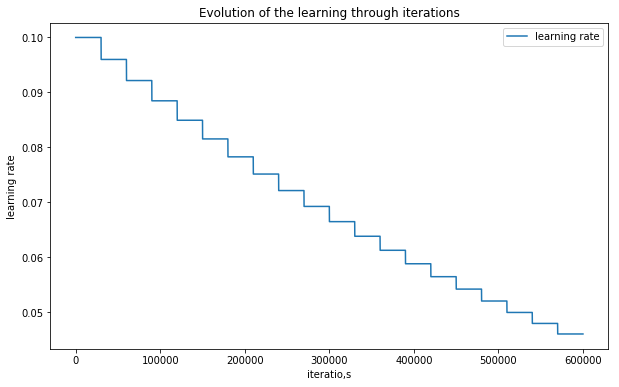

In [ ]:
# Plot the learning rate
plt.figure(figsize=(10, 6))
plt.plot(l_rate_v, label="learning rate")
plt.legend(loc='best')
plt.ylabel('learning rate')
plt.xlabel('iteratio,s')
plt.title('Evolution of the learning through iterations')
plt.show()

#### Normalized predictions against normalized original values
Use to check whether the denormalization process is consistent

In [ ]:
# Plot normalized predictions vs normalized original
fig = plt.figure(figsize=(10, 7))
plt.plot(y_test_norm, label='Original')
plt.plot(pred_test_norm, label='Predicted')
plt.xlabel('item')
plt.ylabel('number of units sales')
plt.legend(loc='best')
plt.title('Evolution of the normalized units sales - Grocery store')
plt.show()

#### Predictions against original values

In [ ]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), y_test, label="Original Data")
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

#### Predictions only
Use to observe more precisely the predictions

In [ ]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

## V - Reccurent neural network

### A - Model initialization

#### Input data

In [ ]:
nb_inputs = X_train.shape[0]
num_components = X_train.shape[1]

nb_epoch = 50
num_hidden = 32
learning_rate = 0.001
lambda_loss = 0.001
batch_size = 1000

acc_t = []
loss_t = []
acc_val = []
loss_val = []

#### Graph definition

In [ ]:
graph = tf.Graph()
with graph.as_default():
    # 1) First we put the input data in a tensorflow friendly form.
    X_tf = tf.placeholder(tf.float32, shape=(None, nb_inputs,
                                             num_components))
    y_tf = tf.placeholder(tf.float32)

    # 2) Then we choose the model to calculate the logits (predicted labels)
    # We can choose from several models:
    logits = rnn_model(X_tf, num_hidden)
    # logits = lstm_rnn_model(tf_dataset, num_hidden, num_labels)

    # 3) Then we compute the softmax cross entropy between the logits and
    # the (actual) labels
    l2 = lambda_loss * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_tf)) + l2

    # 4)
    # The optimizer is used to calculate the gradients of the loss function
    # optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    prediction = tf.nn.softmax(logits)

### B - Model training

In [ ]:
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print("\nInitialized")

    for epoch in tqdm(range(nb_epoch)):

        # Create the batches
        total_batch = int(X_train.shape[0]/batch_size)

        # Run training on batch
        for i in range(total_batch):
            # Since we are using stochastic gradient descent, we are selecting
            # small batches from the training dataset, and training the
            # convolutional neural network each time with a batch.
            batch_X = X_train_norm[i*batch_size:(i+1)*batch_size]
            batch_y = y_train_norm[i*batch_size:(i+1)*batch_size]

            feed_dict = {X_tf: batch_X, y_tf: batch_y}
            _, l, train_predictions = sess.run([optimizer, loss, prediction],
                                               feed_dict=feed_dict)
            train_accuracy = accuracy(train_predictions, batch_y)
        acc_t.append(train_accuracy)
        loss_t.append(l)

        feed_dict = {X_tf: X_valid_norm, y_tf: y_valid_norm}
        l_val, valid_predictions = sess.run([loss, prediction],
                                            feed_dict=feed_dict)
        valid_accuracy = accuracy(valid_predictions, y_valid_norm)
        print('Epoch ', str(epoch), ': ', ' - Accuracy on train set:',
                train_accuracy, ' - Accuract on valid set:',  valid_accuracy)

        acc_val.append(valid_accuracy)
        loss_val.append(l_val)

    # Test set
    feed_dict = {X_tf: X_test_norm, y_tf: y_test_norm}
    _, test_predictions = sess.run([loss, prediction], feed_dict=feed_dict)
    valid_accuracy = accuracy(test_predictions, y_test_norm)
    print('Accuracy on test set:', valid_accuracy)

    # Close the session
    sess.close()

#### Denormalize predictions

In [ ]:
pred_test = denormalize(y_test, test_predictions)

### C - Visualization

#### Cost of the prediction

In [ ]:
# Plot the costs
fig, ax1 = plt.subplots(figsize=(10, 7))
x = np.arange(nb_epoch)
ax1.plot(x, loss_t, 'b-')
ax1.set_xlabel('epochs')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Avg Cost train', color='C0')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(x, loss_val, 'r-')
ax2.set_ylabel('Cost valid', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')  
plt.show()

#### Predictions against original values

In [ ]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), y_test, label="Original Data")
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()